# Plots of ICESat-2/ATLAS transects at field sites

with field observations at ground level (TODO) and from UAV 

https://docs.google.com/spreadsheets/d/1jqP0K0LZmswK4ZZNU6BxKYgjaBZM0HRkUrWS1QFLvIE/edit?gid=0#gid=0  

could be used for manuscript:
https://docs.google.com/document/d/1uj9-xlLTJK1xeGvzIEHvNNnquXYMUNsBDB30a3HhlOc/edit?usp=sharing

| Author | Affiliation | Date |
| --- | --- | --- |
| Paul Montesano, PhD | Innovation Lab ; NASA Goddard Space Flight Center | Sept. 2024 |

In [1]:
import os
import pandas as pd
import geopandas as gpd
import glob
import rasterio
import pyproj
import matplotlib.pyplot as plt
import warnings
import folium
from folium import plugins
import fiona
import numpy as np
from basemaplib import *

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_906398/4279244517.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/panfs/ccds02/app/modules/jupyter/ilab/tensorflow-kernel/lib/python3.8/site-packages/pyproj/../../.././libtiff.so.6: version `LIBTIFF_4.6.1' not found (required by /app/jupyter/ilab/jupyter-lab/prod/lib

In [2]:
import plotnine
from plotnine import *

### CHM model training chips

In [3]:
# chips_df_ifsar_chm_gdf = gpd.read_file('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/chips_df_ifsar_chm_nodtm_v20231014.gpkg')
# chips_df_lidar_chm_gdf = gpd.read_file('/explore/nobackup/people/mmacande/srlite/chm_model/20231014_chm/chips_df_lidar_nodtm_v20231014.gpkg')

In [4]:
class_name_list =  list(reversed(['Noise','Ground','Canopy','Top of canopy'][1:]))
class_color_list = list(reversed(['lightgrey','brown','lightgreen','darkgreen'][1:]))

In [5]:
EXPEDITION_ID = 'sewardpen2024'
OUTDIR = f'/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/field/{EXPEDITION_ID}'
OUTDIR_PLOTS = '/explore/nobackup/projects/above/misc/ABoVE_Shrubs/plots'

### UAV data footprints

In [6]:
footprint_uav_gdf = gpd.read_file(f'{OUTDIR}/footprints_uav_sewardpen2024_RGB_COG.gpkg')

## Read tables: Raster CHM extractions at field points

In [67]:
# Read seward reference data frame
all_ref_m = pd.read_csv(os.path.join(OUTDIR, 'sewardpen2024_all_rs_validation.csv'))
#all_ref_gdf_extract = gpd.read_file(os.path.join(OUTDIR, 'sewardpen2024_all_rs_validation_unmelted.gpkg'))

/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_906398/2903023123.py:2: DtypeWarning: Columns (13,17) have mixed types. Specify dtype option on import or set low_memory=False.


## Exploratory plotting

In [68]:
import numpy as np
import pandas as pd
from plotnine import *
from scipy import stats
from sklearn import metrics

In [69]:
# DATA PREPARATION FUNCTIONS
# =============================================================================

def prepare_dataframe(all_ref_m):
    """Clean and prepare the dataframe for analysis."""
    
    # Set categorical ordering
    all_ref_m['source_extent'] = pd.Categorical(
        all_ref_m['source_extent'], 
        categories=['Global', 'Circumpolar', 'Regional', 'Local']
    )
    all_ref_m['source_cat'] = pd.Categorical(
        all_ref_m['source_cat'], 
        categories=['Observation', 'Machine Learning', 'Deep Learning']
    )
    
    # Filter data
    df = all_ref_m[
        (all_ref_m.value != -9999) & 
        (all_ref_m.value != 255) &
        (
            (all_ref_m.type_ref == 'field 2m') | 
            (all_ref_m.type_ref == 'field 0.3m')
        ) &
        ~((all_ref_m.source_type == 'VHR CHM v1.0 (UNet)') & 
          (all_ref_m.source_res == '10m'))
    ].copy()
    
    # Parse source column
    df.rename(columns=lambda x: x.split('chm_')[0], inplace=True)
    df[['source_simple', 'source_extra1']] = df['source'].str.split('chm_', n=1, expand=True)
    df[['source_simple', 'source_extra2']] = df['source_simple'].str.split('cnn', n=1, expand=True)
    df[['source_extra3', 'source_simple']] = df['source_simple'].str.split('ht_', n=1, expand=True)
    
    return df

def apply_scaling(df, scale_config):
    """Apply scaling to specific model predictions."""
    active_patterns = [p for p, enabled in scale_config.items() if enabled]
    if active_patterns:
        pattern = '|'.join(active_patterns)
        mask = df['source_type'].str.contains(pattern, case=True, na=False)
        df.loc[mask, 'value'] = df.loc[mask, 'value'] / 10
    return df

def filter_models(df, include_config):
    """Filter dataframe to include only specified models."""
    active_patterns = [p for p, enabled in include_config.items() if enabled]
    if active_patterns:
        pattern = '|'.join(active_patterns)
        df = df[df['source_type'].str.contains(pattern, case=True, na=False)]
    return df

def apply_filters(df, filter_config):
    """Apply additional data filters."""
    df = df[df['type_ref'].isin(filter_config['reference_types'])]
    df = df[~df['source_res'].isin(filter_config['exclude_resolutions'])]
    df = df[~df['source_type'].isin(filter_config['exclude_types'])]
    return df

# =============================================================================
# STATISTICAL FUNCTIONS
# =============================================================================

def calculate_validation_stats(group, ref_col='height_ref', pred_col='value'):
    """Calculate comprehensive validation statistics."""
    from scipy import stats as sp_stats
    from sklearn import metrics
    n = len(group)
    ref = group[ref_col]
    pred = group[pred_col]
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = sp_stats.linregress(ref, pred)
    
    # Performance metrics
    stats_dict = {
        'n': n,
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'r2': r_value ** 2,
        'p_value': p_value,
        'std_err': std_err,
        'rmse': np.sqrt(metrics.mean_squared_error(ref, pred)),
        'mae': metrics.mean_absolute_error(ref, pred),
        'medae': metrics.median_absolute_error(ref, pred),
        'mse': metrics.mean_squared_error(ref, pred),
        'exp_var': metrics.explained_variance_score(ref, pred),
        'bias': np.mean(pred - ref),
    }
    
    return pd.Series(stats_dict)

def format_stats_labels(stats_df):
    """Create formatted label strings for plot annotations."""
    stats_df['label_r2'] = stats_df['r2'].apply(lambda x: f"$R^2$ = {x:.3f}")
    stats_df['label_rmse'] = stats_df['rmse'].apply(lambda x: f"RMSE = {x:.2f} m")
    stats_df['label_mae'] = stats_df['mae'].apply(lambda x: f"MAE = {x:.2f} m")
    stats_df['label_bias'] = stats_df['bias'].apply(lambda x: f"Bias = {x:.2f} m")
    stats_df['label_n'] = stats_df['n'].apply(lambda x: f"n = {x:,}")
    return stats_df

def create_facet_label(df, facet_vars):
    """Create a combined facet label from multiple variables."""
    # Create a shorter, more readable label
    label_parts = []
    for var in facet_vars:
        if var in df.columns:
            label_parts.append(df[var].astype(str))
    
    if label_parts:
        df['facet_label'] = label_parts[0]
        for part in label_parts[1:]:
            df['facet_label'] = df['facet_label'] + '\n' + part
    else:
        df['facet_label'] = 'All Data'
    
    return df

def format_stats_labels(stats_df):
    """Create formatted label strings for plot annotations."""
    # Filter out rows with NaN values first
    stats_df = stats_df.dropna(subset=['r2', 'rmse', 'mae', 'bias', 'n'])
    
    stats_df['label_r2'] = stats_df['r2'].apply(lambda x: f"$R^2$ = {x:.3f}")
    stats_df['label_rmse'] = stats_df['rmse'].apply(lambda x: f"RMSE = {x:.2f} m")
    stats_df['label_mae'] = stats_df['mae'].apply(lambda x: f"MAE = {x:.2f} m")
    stats_df['label_bias'] = stats_df['bias'].apply(lambda x: f"Bias = {x:.2f} m")
    stats_df['label_n'] = stats_df['n'].apply(lambda x: f"n = {x:,}")
    
    # Create a combined stats label to reduce overplotting
    stats_df['combined_stats'] = (
        stats_df['label_n'] + '\n' +
        stats_df['label_r2'] + '\n' +
        stats_df['label_rmse'] + '\n' +
        stats_df['label_mae'] + '\n' +
        stats_df['label_bias']
    )
    
    return stats_df

def create_validation_plot_wrap(df, group_vars, facet_vars, config=PLOT_CONFIG):
    """Create validation plot using facet_wrap for better handling of long labels."""
    
    # Create combined facet label
    df = create_facet_label(df, facet_vars)
    group_vars_with_facet = group_vars + ['facet_label']
    
    # Calculate statistics
    summary_df = (
        df.groupby(group_vars_with_facet)
        .apply(calculate_validation_stats)
        .reset_index()
        .round(3)
    )
    
    # Filter out any rows with insufficient data (< 10 points)
    summary_df = summary_df[summary_df['n'] >= 10].copy()
    summary_df = format_stats_labels(summary_df)
    
    max_val = config['max_height']
    lab_sz = config['label_size']
    
    # Create plot
    p = (
        ggplot(df, aes(x='height_ref', y='value'))
        
        # Main elements
        + geom_bin2d(binwidth=config['binwidth'])
        + geom_abline(color='red', linetype='dashed', size=0.8, alpha=0.7)
        
        # Add background rectangle for stats text
        + geom_rect(
            data=summary_df,
            mapping=aes(xmin=0, xmax=max_val*0.45, ymin=max_val*0.60, ymax=max_val),
            fill='white', alpha=0.85, inherit_aes=False
        )
        
        # Statistics labels
        + geom_text(
            data=summary_df, 
            mapping=aes(x=max_val*0.02, y=max_val*0.96, label='label_n'),
            ha='left', va='top', size=lab_sz, color='black', fontweight='bold',
            inherit_aes=False
        )
        + geom_text(
            data=summary_df, 
            mapping=aes(x=max_val*0.02, y=max_val*0.89, label='label_r2'),
            ha='left', va='top', size=lab_sz, color='black', fontweight='bold',
            inherit_aes=False
        )
        + geom_text(
            data=summary_df, 
            mapping=aes(x=max_val*0.02, y=max_val*0.82, label='label_rmse'),
            ha='left', va='top', size=lab_sz, color='black', fontweight='bold',
            inherit_aes=False
        )
        + geom_text(
            data=summary_df, 
            mapping=aes(x=max_val*0.02, y=max_val*0.75, label='label_mae'),
            ha='left', va='top', size=lab_sz, color='black', fontweight='bold',
            inherit_aes=False
        )
        + geom_text(
            data=summary_df, 
            mapping=aes(x=max_val*0.02, y=max_val*0.68, label='label_bias'),
            ha='left', va='top', size=lab_sz, color='black', fontweight='bold',
            inherit_aes=False
        )
        
        # Scales and coordinates
        + scale_fill_cmap(
            cmap_name=config['color_scheme'], 
            trans='log10', 
            name='Observations'
        )
        + coord_cartesian(xlim=(0, max_val), ylim=(0, max_val))
        
        # Labels and theme
        + labs(
            x='Reference vegetation height (m)', 
            y='Predicted vegetation height (m)',
            title='Vegetation Height Model Validation\nSeward Peninsula, Alaska - Field Reference Comparison'
        )
        + facet_wrap('~facet_label', ncol=config['facet_ncol'], labeller='label_value')
        + theme_bw()
        + theme(
            figure_size=config['figure_size'],
            strip_text=element_text(size=10
                                    #, face='bold'
                                    , margin={'t': 5, 'b': 5}),
            strip_background=element_rect(fill='lightgray', alpha=0.5),
            axis_text=element_text(size=11),
            axis_title=element_text(size=12, face='bold'),
            plot_title=element_text(size=14, face='bold'),
            legend_position='right',
            panel_spacing=0.3,
            panel_grid_major=element_line(color='gray', size=0.3, alpha=0.5),
            panel_grid_minor=element_line(color='gray', size=0.15, alpha=0.3)
        )
    )
    
    return p, summary_df

# Alternative version with horizontal layout (fewer columns, more rows)
def create_validation_plot_wrap_horizontal(df, group_vars, facet_vars, config=PLOT_CONFIG):
    """Create validation plot with horizontal layout (2 columns) for very long labels."""
    
    # Create combined facet label
    df = create_facet_label(df, facet_vars)
    group_vars_with_facet = group_vars + ['facet_label']
    
    # Calculate statistics
    stats_df = (
        df.groupby(group_vars_with_facet)
        .apply(calculate_validation_stats)
        .reset_index()
        .round(3)
    )
    stats_df = format_stats_labels(stats_df)
    
    max_val = config['max_height']
    lab_sz = config['label_size']
    
    # Adjust figure size for 2-column layout
    config_copy = config.copy()
    config_copy['figure_size'] = (14, 20)  # Narrower, taller
    
    # Create plot
    p = (
        ggplot(df, aes(x='height_ref', y='value'))
        
        # Main elements
        + geom_bin2d(binwidth=config['binwidth'])
        + geom_abline(color='red', linetype='dashed', size=0.8, alpha=0.7)
        
        # Statistics labels
        + geom_label(
            data=stats_df, 
            mapping=aes(x=0.5, y=max_val*0.95, label='label_n'),
            ha='left', va='top', size=lab_sz, fill='white', alpha=0.85
        )
        + geom_label(
            data=stats_df, 
            mapping=aes(x=0.5, y=max_val*0.88, label='label_r2'),
            ha='left', va='top', size=lab_sz, fill='white', alpha=0.85
        )
        + geom_label(
            data=stats_df, 
            mapping=aes(x=0.5, y=max_val*0.81, label='label_rmse'),
            ha='left', va='top', size=lab_sz, fill='white', alpha=0.85
        )
        + geom_label(
            data=stats_df, 
            mapping=aes(x=0.5, y=max_val*0.74, label='label_mae'),
            ha='left', va='top', size=lab_sz, fill='white', alpha=0.85
        )
        + geom_label(
            data=stats_df, 
            mapping=aes(x=0.5, y=max_val*0.67, label='label_bias'),
            ha='left', va='top', size=lab_sz, fill='white', alpha=0.85
        )
        
        # Scales and coordinates
        + scale_fill_cmap(
            cmap_name=config['color_scheme'], 
            trans='log10', 
            name='Observations'
        )
        + coord_cartesian(xlim=(0, max_val), ylim=(0, max_val))
        
        # Labels and theme
        + labs(
            x='Reference vegetation height (m)', 
            y='Predicted vegetation height (m)',
            title='Vegetation Height Model Validation',
            caption='Seward Peninsula, Alaska - Field Reference Comparison'
        )
        + facet_wrap('~facet_label', ncol=2, labeller='label_value')  # 2 columns
        + theme_bw()
        + theme(
            figure_size=config_copy['figure_size'],
            strip_text=element_text(size=9, face='bold', margin={'t': 5, 'b': 5}),
            strip_background=element_rect(fill='lightgray', alpha=0.5),
            axis_text=element_text(size=10),
            axis_title=element_text(size=11, face='bold'),
            plot_title=element_text(size=13, face='bold'),
            #plot_subtitle=element_text(size=10),
            legend_position='right',
            panel_spacing=0.4,
            panel_grid_major=element_line(color='gray', size=0.3, alpha=0.5),
            panel_grid_minor=element_line(color='gray', size=0.15, alpha=0.3)
        )
    )
    
    return p, stats_df

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def run_validation_analysis(all_ref_m, PLOT_CONFIG, FILTER_CONFIG, output_dir=None, use_horizontal=False):
    """Main function to run the complete validation analysis."""
    
    # Prepare data
    print("Preparing dataframe...")
    df = prepare_dataframe(all_ref_m)
    df = apply_scaling(df, FILTER_CONFIG['scale_by_10'])
    df = filter_models(df, FILTER_CONFIG['include_models'])
    df = apply_filters(df, FILTER_CONFIG)
    
    print(f"Filtered data shape: {df.shape}")
    print(f"Unique models: {df['source_type'].unique()}")
    
    # Set plot configuration
    plotnine.options.figure_size = PLOT_CONFIG['figure_size']
    
    # Define grouping and faceting variables
    group_vars = ['type_ref', 'source_extent', 'source_cat']
    facet_vars = ['source_cat', 'source_type']  # Variables to combine in facet label
    
    # Create plot
    print("Creating plots...")
    if use_horizontal:
        plot, stats = create_validation_plot_wrap_horizontal(
            df, 
            group_vars=group_vars,
            facet_vars=facet_vars,
            config=PLOT_CONFIG
        )
    else:
        plot, stats = create_validation_plot_wrap(
            df, 
            group_vars=group_vars,
            facet_vars=facet_vars,
            config=PLOT_CONFIG
        )
    
    # # Display statistics summary
    # print("\n=== Validation Statistics Summary ===")
    # print(stats[['source_type', 'n', 'r2', 'rmse', 'mae', 'bias']].to_string(index=False))
    
    # Save plot if output directory provided
    if output_dir:
        import os
        layout_type = 'horizontal' if use_horizontal else 'wrap'
        filename = os.path.join(output_dir, f'validation_plot_{layout_type}.png')
        plot.save(filename=filename, dpi=PLOT_CONFIG['dpi'], verbose=False)
        print(f"\nPlot saved to: {filename}")
        
        # Save statistics
        stats_file = os.path.join(output_dir, f'validation_statistics_{layout_type}.csv')
        stats.to_csv(stats_file, index=False)
        print(f"Statistics saved to: {stats_file}")
    
    return plot, stats


In [75]:
# =============================================================================
# CONFIGURATION
# =============================================================================

PLOT_CONFIG = {
    'figure_size': (15, 15),  # Adjusted for wrap layout
    'max_height': 6,
    'binwidth': 0.25,
    'label_size': 8,
    'dpi': 300,
    'color_scheme': 'plasma',  # or 'plasma', 'inferno', 'magma'
    'facet_ncol': 4,  # Number of columns in facet_wrap
}

FILTER_CONFIG = {
    'include_models': {
        'UNet': True,
        'DINOv2': True,
        'DINOv3': True,
    },
    'scale_by_10': {
        'CHM v2.1': True,
        'CHM v2.2.3': True,
        'CHM v2.2.4': True,
        'DINOv3': True,
    },
    'reference_types': ['field 2m'],
    'exclude_resolutions': ['10m'],
    'exclude_types': ['UAV'],
}

Preparing dataframe...
Filtered data shape: (10350, 23)
Unique models: ['VHR CHM v3.3.2.2 (DINOv3)' 'VHR CHM v3.3.2.3 (DINOv3)'
 'VHR CHM v3.3.2.4 (DINOv3)' 'VHR CHM v4.3.2.2 (DINOv3)'
 'VHR CHM v4.3.2.3 (DINOv3)']
Creating plots...


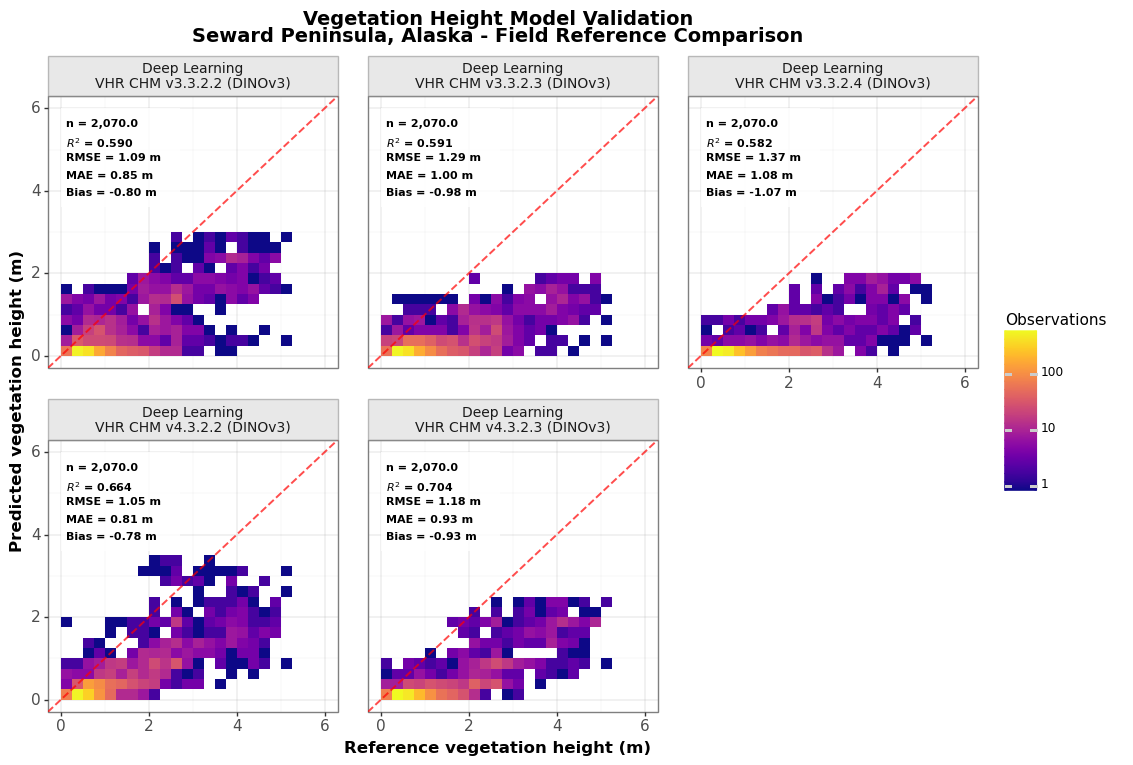

In [81]:
# Standard wrap layout (3 columns)
plot, stats = run_validation_analysis(all_ref_m, 
                                      PLOT_CONFIG = {
    'figure_size': (12, 8),  # Adjusted for wrap layout
    'max_height': 6,
    'binwidth': 0.25,
    'label_size': 8,
    'dpi': 300,
    'color_scheme': 'plasma',  # or 'plasma', 'inferno', 'magma'
    'facet_ncol': 3,  # Number of columns in facet_wrap
}, 
                                      FILTER_CONFIG = {
    'include_models': {
        'UNet': False,
        'DINOv2': False,
        #'DINOv3': True,
        '.3.2.1': False, '.3.2.2': True, '.3.2.3': True, '.3.2.4': True,
    },
    'scale_by_10': {
        'CHM v2.1': True,
        'CHM v2.2.3': True,
        'CHM v2.2.4': True,
        'DINOv3': True,
    },
    'reference_types': ['field 2m'],
    'exclude_resolutions': ['10m'],
    'exclude_types': [''], #['UAV'],
}
                                     )
print(plot)

In [72]:
# Standard wrap layout (3 columns)
plot, stats = run_validation_analysis(all_ref_m)
print(plot)

TypeError: run_validation_analysis() missing 2 required positional arguments: 'PLOT_CONFIG' and 'FILTER_CONFIG'

Preparing dataframe...
Filtered data shape: (26766, 23)
Unique models: ['VHR CHM v1.0 (UNet)' 'VHR CHM v2.1 (ViT DINOv2)'
 'VHR CHM v2.2.1 (ViT DINOv2-RS)' 'VHR CHM v2.2.2 (ViT DINOv2-RS)'
 'VHR CHM v2.2.3 (ViT DINOv2-RS)' 'VHR CHM v2.2.4 (ViT DINOv2-RS)'
 'VHR CHM v1.5.1 (UNet)' 'VHR CHM v1.5.2 (UNet)'
 'VHR CHM v3.3.2.1 (DINOv3)' 'VHR CHM v3.3.2.2 (DINOv3)'
 'VHR CHM v3.3.2.3 (DINOv3)' 'VHR CHM v3.3.2.4 (DINOv3)'
 'VHR CHM v4.3.2.3 (DINOv3)']
Creating plots...


/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_906398/2193868562.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_906398/2193868562.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/explore/nobackup/people/pmontesa/.nccstmp/ipykernel_906398/2193868562.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

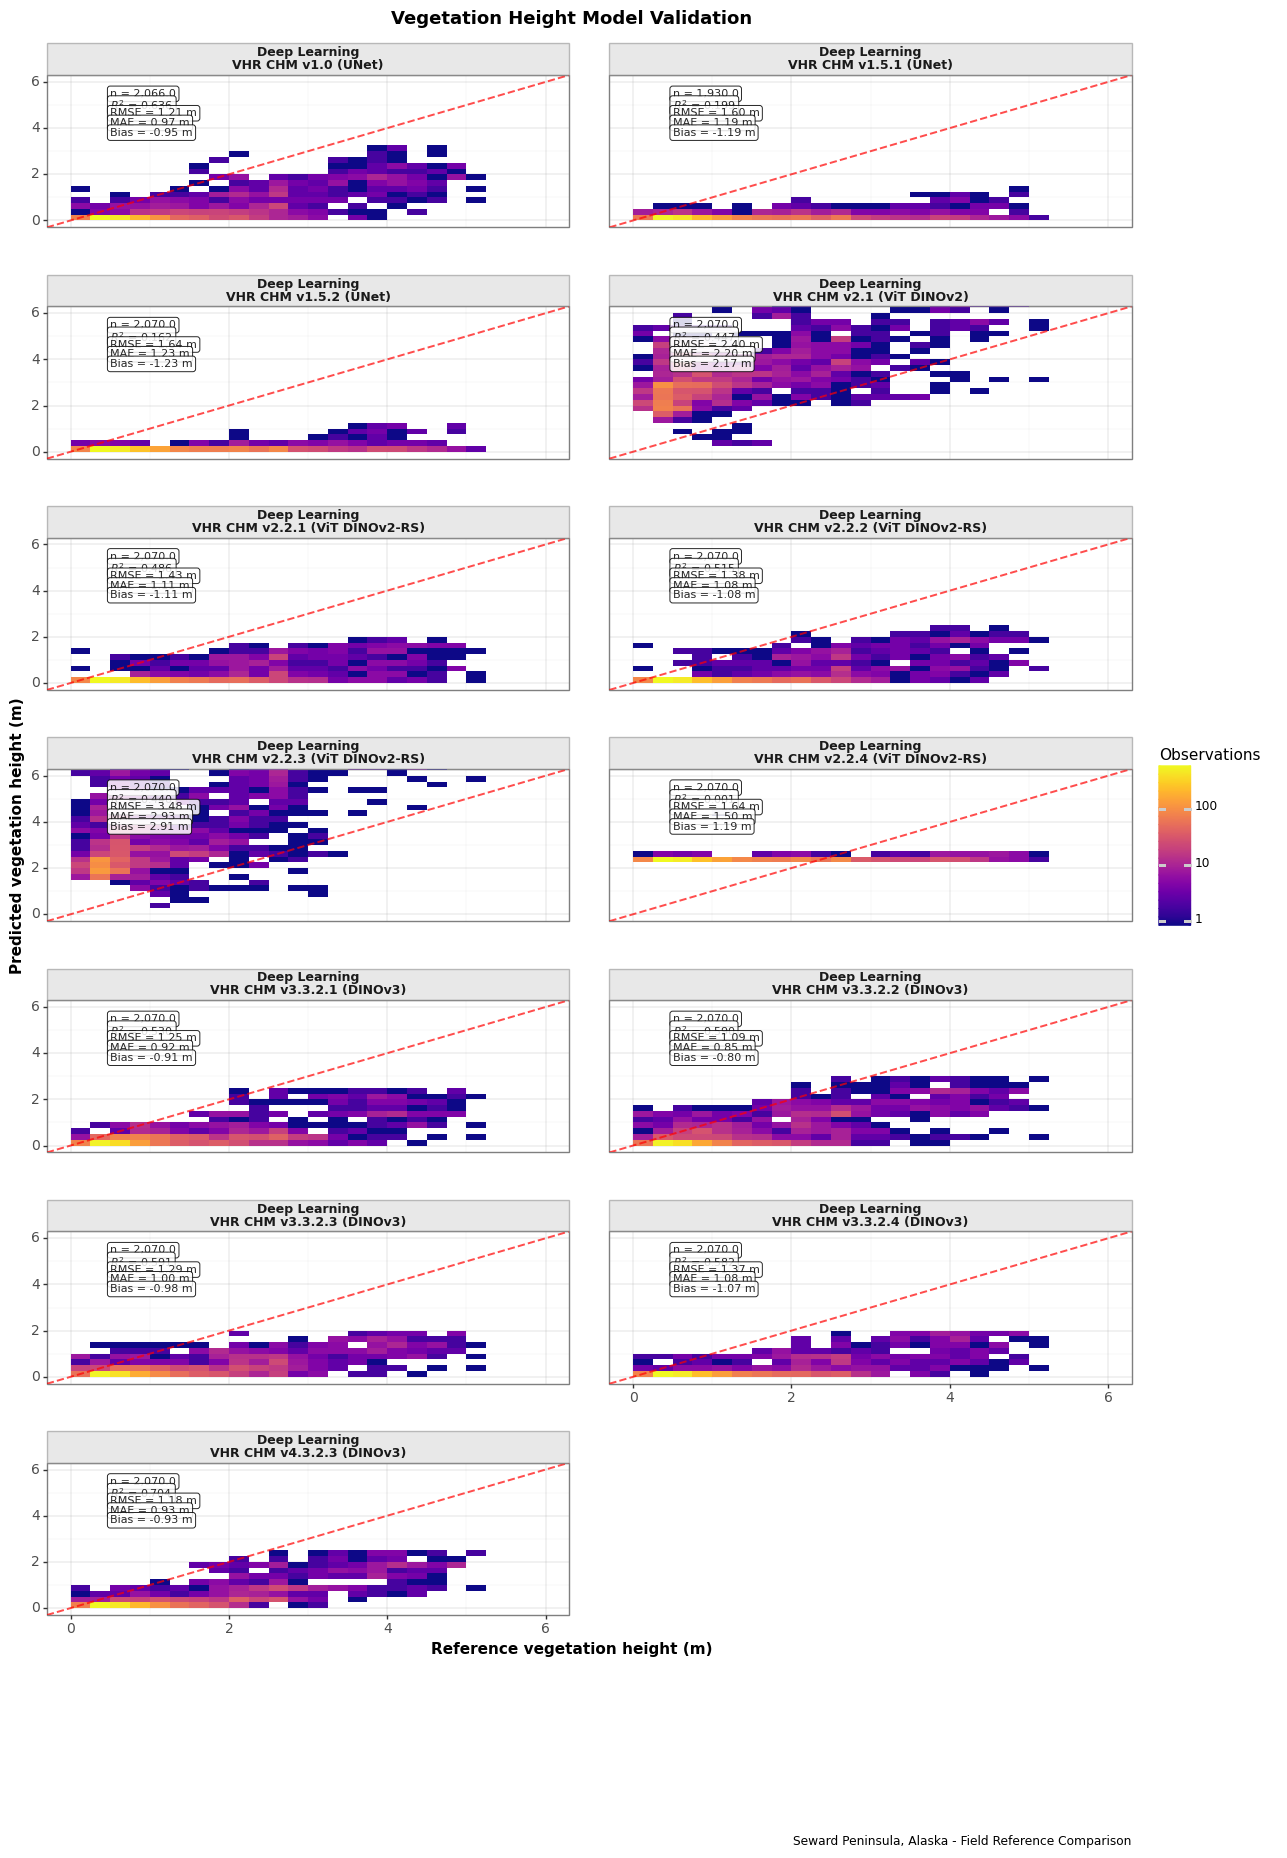

In [58]:
# Or use horizontal layout (2 columns) for very long labels:
plot, stats = run_validation_analysis(all_ref_m, use_horizontal=True)
print(plot)

In [83]:
import numpy as np
import pandas as pd
from plotnine import *
from scipy import stats as sp_stats
from sklearn import metrics

# =============================================================================
# CONFIGURATION
# =============================================================================

PLOT_CONFIG = {
    'figure_size': (20, 16),
    'max_height': 10,
    'binwidth': 0.25,
    'label_size': 8,
    'dpi': 300,
    'color_scheme': 'viridis',
    'facet_ncol': 3,
}

FILTER_CONFIG = {
    'include_models': {
        'UNet': True,
        'DINOv2': True,
        'DINOv3': True,
    },
    'scale_by_10': {
        'CHM v2.1': True,
        'CHM v2.2.3': True,
        'DINOv3': True,
    },
    'reference_types': ['field 2m'],
    'exclude_resolutions': ['10m'],
    'exclude_types': ['UAV'],
}

# =============================================================================
# MODEL ATTRIBUTE MAPPINGS
# =============================================================================

MODEL_ATTRIBUTES = {
    'VHR CHM v1.0 (UNet)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v1.5.1 (UNet)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v1.5.2 (UNet)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v2.1 (ViT DINOv2)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v2.2.1 (ViT DINOv2-RS)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v2.2.2 (ViT DINOv2-RS)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v2.2.3 (ViT DINOv2-RS)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v2.2.4 (ViT DINOv2-RS)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v3.3.2.1 (DINOv3)': {
        'loss_function': '??',
        'training_size': 'Small (10K)',
    },
    'VHR CHM v3.3.2.2 (DINOv3)': {
        'loss_function': 'custom',
        'training_size': 'Large (100K)',
    },
    'VHR CHM v3.3.2.3 (DINOv3)': {
        'loss_function': 'MAE',
        'training_size': 'Large (100K)',
    },
    'VHR CHM v3.3.2.4 (DINOv3)': {
        'loss_function': 'MSE',
        'training_size': 'Large (100K)',
    },
    'VHR CHM v4.3.2.2 (DINOv3)': {
        'loss_function': 'custom',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v4.3.2.3 (DINOv3)': {
        'loss_function': 'MAE',
        'training_size': 'Full (400K)',
    },
    'VHR CHM v4.3.2.4 (DINOv3)': {
        'loss_function': 'MSE',
        'training_size': 'Full (400K)',
    },
    # Add more models as needed
}

In [100]:


# Default values for models not in the mapping
DEFAULT_ATTRIBUTES = {
    'loss_function': 'Unknown',
    'training_size': 'Unknown',
}

# =============================================================================
# DATA PREPARATION FUNCTIONS
# =============================================================================

def add_model_attributes(df, attribute_mapping=MODEL_ATTRIBUTES, default_attrs=DEFAULT_ATTRIBUTES):
    """Add loss_function and training_size attributes based on source_type."""
    
    # Initialize with default values
    for attr, default_value in default_attrs.items():
        df[attr] = default_value
    
    # Map attributes for each model
    for source_type, attributes in attribute_mapping.items():
        mask = df['source_type'] == source_type
        for attr, value in attributes.items():
            df.loc[mask, attr] = value
    
    # Set categorical ordering for better plot organization
    df['loss_function'] = pd.Categorical(
        df['loss_function'],
        categories=['MSE', 'MAE', 'custom'],
        ordered=True
    )
    
    df['training_size'] = pd.Categorical(
        df['training_size'],
        categories=[
            #'Small (10K)', 
            'Medium (50K)', 'Large (100K)', 'Full (400K)'
            #        , 'Unknown'
        ],
        ordered=True
    )
    
    return df

def prepare_dataframe(all_ref_m):
    """Clean and prepare the dataframe for analysis."""
    
    # Set categorical ordering
    all_ref_m['source_extent'] = pd.Categorical(
        all_ref_m['source_extent'], 
        categories=['Global', 'Circumpolar', 'Regional', 'Local']
    )
    all_ref_m['source_cat'] = pd.Categorical(
        all_ref_m['source_cat'], 
        categories=['Observation', 'Machine Learning', 'Deep Learning']
    )
    
    # Filter data
    df = all_ref_m[
        (all_ref_m.value != -9999) & 
        (all_ref_m.value != 255) &
        (
            (all_ref_m.type_ref == 'field 2m') | 
            (all_ref_m.type_ref == 'field 0.3m')
        ) &
        ~((all_ref_m.source_type == 'VHR CHM v1.0 (UNet)') & 
          (all_ref_m.source_res == '10m'))
    ].copy()
    
    # Parse source column
    df.rename(columns=lambda x: x.split('chm_')[0], inplace=True)
    df[['source_simple', 'source_extra1']] = df['source'].str.split('chm_', n=1, expand=True)
    df[['source_simple', 'source_extra2']] = df['source_simple'].str.split('cnn', n=1, expand=True)
    df[['source_extra3', 'source_simple']] = df['source_simple'].str.split('ht_', n=1, expand=True)
    
    # Add model attributes
    df = add_model_attributes(df)
    
    return df

def apply_scaling(df, scale_config):
    """Apply scaling to specific model predictions."""
    active_patterns = [p for p, enabled in scale_config.items() if enabled]
    if active_patterns:
        pattern = '|'.join(active_patterns)
        mask = df['source_type'].str.contains(pattern, case=True, na=False)
        df.loc[mask, 'value'] = df.loc[mask, 'value'] / 10
    return df

def filter_models(df, include_config):
    """Filter dataframe to include only specified models."""
    active_patterns = [p for p, enabled in include_config.items() if enabled]
    if active_patterns:
        pattern = '|'.join(active_patterns)
        df = df[df['source_type'].str.contains(pattern, case=True, na=False)]
    return df

def apply_filters(df, filter_config):
    """Apply additional data filters."""
    df = df[df['type_ref'].isin(filter_config['reference_types'])]
    df = df[~df['source_res'].isin(filter_config['exclude_resolutions'])]
    df = df[~df['source_type'].isin(filter_config['exclude_types'])]
    return df

# =============================================================================
# STATISTICAL FUNCTIONS
# =============================================================================

def calculate_validation_stats(group, ref_col='height_ref', pred_col='value'):
    """Calculate comprehensive validation statistics."""
    
    n = len(group)
    ref = group[ref_col]
    pred = group[pred_col]
    
    # Linear regression
    slope, intercept, r_value, p_value, std_err = sp_stats.linregress(ref, pred)
    
    # Performance metrics
    stats_dict = {
        'n': n,
        'slope': slope,
        'intercept': intercept,
        'r_value': r_value,
        'r2': r_value ** 2,
        'p_value': p_value,
        'std_err': std_err,
        'rmse': np.sqrt(metrics.mean_squared_error(ref, pred)),
        'mae': metrics.mean_absolute_error(ref, pred),
        'medae': metrics.median_absolute_error(ref, pred),
        'mse': metrics.mean_squared_error(ref, pred),
        'exp_var': metrics.explained_variance_score(ref, pred),
        'bias': np.mean(pred - ref),
    }
    
    return pd.Series(stats_dict)

def format_stats_labels(stats_df):
    """Create formatted label strings for plot annotations."""
    # Filter out rows with NaN values first
    stats_df = stats_df.dropna(subset=['r2', 'rmse', 'mae', 'bias', 'n'])
    
    stats_df['label_r2'] = stats_df['r2'].apply(lambda x: f"$R^2$ = {x:.3f}")
    stats_df['label_rmse'] = stats_df['rmse'].apply(lambda x: f"RMSE = {x:.2f} m")
    stats_df['label_mae'] = stats_df['mae'].apply(lambda x: f"MAE = {x:.2f} m")
    stats_df['label_bias'] = stats_df['bias'].apply(lambda x: f"Bias = {x:.2f} m")
    stats_df['label_n'] = stats_df['n'].apply(lambda x: f"n = {x:,}")
    
    # Create a combined stats label
    stats_df['combined_stats'] = (
        stats_df['label_n'] + '\n' +
        stats_df['label_r2'] + '\n' +
        stats_df['label_rmse'] + '\n' +
        stats_df['label_mae'] + '\n' +
        stats_df['label_bias']
    )
    
    return stats_df

def create_facet_label(df, facet_vars):
    """Create a combined facet label from multiple variables."""
    label_parts = []
    for var in facet_vars:
        if var in df.columns:
            label_parts.append(df[var].astype(str))
    
    if label_parts:
        df['facet_label'] = label_parts[0]
        for part in label_parts[1:]:
            df['facet_label'] = df['facet_label'] + '\n' + part
    else:
        df['facet_label'] = 'All Data'
    
    return df

# =============================================================================
# PLOTTING FUNCTIONS
# =============================================================================

def create_validation_plot_wrap(df, group_vars, facet_vars, config=PLOT_CONFIG):
    """Create validation plot using facet_wrap for better handling of long labels."""
    
    # Create combined facet label
    df = create_facet_label(df, facet_vars)
    group_vars_with_facet = group_vars + ['facet_label']
    
    # Calculate statistics
    summary_df = (
        df.groupby(group_vars_with_facet)
        .apply(calculate_validation_stats)
        .reset_index()
        .round(3)
    )
    
    # Filter out any rows with insufficient data
    summary_df = summary_df[summary_df['n'] >= 10].copy()
    summary_df = format_stats_labels(summary_df)
    
    max_val = config['max_height']
    lab_sz = config['label_size']
    
    # Create plot
    p = (
        ggplot(df, aes(x='height_ref', y='value'))
        
        # Main elements
        + geom_bin2d(binwidth=config['binwidth'])
        + geom_abline(color='red', linetype='dashed', size=0.8, alpha=0.7)
        
        # Add background rectangle for stats text
        + geom_rect(
            data=summary_df,
            mapping=aes(xmin=0, xmax=max_val*0.45, ymin=max_val*0.60, ymax=max_val),
            fill='white', alpha=0.85, inherit_aes=False
        )
        
        # Single combined label
        + geom_label(
            data=summary_df, 
            mapping=aes(x=max_val*0.02, y=max_val*0.82, label='combined_stats'),
            ha='left', va='center', size=lab_sz, 
            label_padding=0.25, label_size=0,
            fill='white', alpha=0.9,
            inherit_aes=False
        )
        
        # Scales and coordinates
        + scale_fill_cmap(
            cmap_name=config['color_scheme'], 
            trans='log10', 
            name='Observations'
        )
        + coord_cartesian(xlim=(0, max_val), ylim=(0, max_val))
        
        # Labels and theme
        + labs(
            x='Reference vegetation height (m)', 
            y='Predicted vegetation height (m)',
            title='Vegetation Height Model Validation\nSeward Peninsula, Alaska - Field Reference Comparison'
        )
        + facet_wrap('~facet_label', ncol=config['facet_ncol'], labeller='label_value')
        + theme_bw()
        + theme(
            figure_size=config['figure_size'],
            strip_text=element_text(size=10, face='bold', margin={'t': 5, 'b': 5}),
            strip_background=element_rect(fill='lightgray', alpha=0.5),
            axis_text=element_text(size=11),
            axis_title=element_text(size=12, face='bold'),
            plot_title=element_text(size=14, face='bold'),
            legend_position='right',
            panel_spacing=0.3,
            panel_grid_major=element_line(color='gray', size=0.3, alpha=0.5),
            panel_grid_minor=element_line(color='gray', size=0.15, alpha=0.3)
        )
    )
    
    return p, summary_df

def create_validation_plot_grid(df, group_vars, facet_row_vars, facet_col_vars, config=PLOT_CONFIG):
    """Create validation plot using facet_grid for structured 2D layouts."""
    
    # Build facet formula
    row_formula = ' + '.join(facet_row_vars) if facet_row_vars else '.'
    col_formula = ' + '.join(facet_col_vars) if facet_col_vars else '.'
    facet_formula = f'{row_formula} ~ {col_formula}'
    
    # Combine all grouping variables and remove duplicates
    all_group_vars = list(set(group_vars + facet_row_vars + facet_col_vars))
    
    # Make a copy and drop rows with NaN in grouping variables
    df_plot = df.copy()
    df_plot = df_plot.dropna(subset=all_group_vars)
    
    print(f"Rows after dropping NaN in grouping vars: {len(df_plot)}")
    
    # Calculate statistics with proper grouping
    summary_df = (
        df_plot.groupby(all_group_vars, observed=True)
        .apply(calculate_validation_stats)
        .reset_index()
        .round(3)
    )
    
    # Filter and format
    summary_df = summary_df[summary_df['n'] >= 10].copy()
    summary_df = format_stats_labels(summary_df)
    
    max_val = config['max_height']
    lab_sz = config['label_size']
    
    # Adjust figure size for grid layout
    config_grid = config.copy()
    # Calculate number of unique values for sizing
    if facet_row_vars:
        row_df = df_plot[facet_row_vars].drop_duplicates()
        n_rows = len(row_df)
    else:
        n_rows = 1
    
    if facet_col_vars:
        col_df = df_plot[facet_col_vars].drop_duplicates()
        n_cols = len(col_df)
    else:
        n_cols = 1
        
    config_grid['figure_size'] = (6 * n_cols, 5 * n_rows)
    
    # Create plot
    p = (
        ggplot(df_plot, aes(x='height_ref', y='value'))
        
        # Main elements
        + geom_bin2d(binwidth=config['binwidth'])
        + geom_abline(color='red', linetype='dashed', size=0.8, alpha=0.7)
        
        # Add background rectangle for stats text
        + geom_rect(
            data=summary_df,
            mapping=aes(xmin=0, xmax=max_val*0.45, ymin=max_val*0.60, ymax=max_val),
            fill='white', alpha=0.85, inherit_aes=False
        )
        
        # Single combined label
        + geom_label(
            data=summary_df, 
            mapping=aes(x=max_val*0.02, y=max_val*0.82, label='combined_stats'),
            ha='left', va='center', size=lab_sz, 
            label_padding=0.25, label_size=0,
            fill='white', alpha=0.9,
            inherit_aes=False
        )
        
        # Scales and coordinates
        + scale_fill_cmap(
            cmap_name=config['color_scheme'], 
            trans='log10', 
            name='Observations'
        )
        + coord_cartesian(xlim=(0, max_val), ylim=(0, max_val))
        
        # Labels and theme
        + labs(
            x='Reference vegetation height (m)', 
            y='Predicted vegetation height (m)',
            title='Vegetation Height Model Validation\nSeward Peninsula, Alaska - Field Reference Comparison'
        )
        + facet_grid(facet_formula, labeller='label_both')
        + theme_bw()
        + theme(
            figure_size=config_grid['figure_size'],
            strip_text_x=element_text(size=10, face='bold'),
            strip_text_y=element_text(size=10, face='bold', angle=0),
            strip_background=element_rect(fill='lightgray', alpha=0.5),
            axis_text=element_text(size=10),
            axis_title=element_text(size=11, face='bold'),
            plot_title=element_text(size=13, face='bold'),
            legend_position='right',
            panel_spacing=0.2,
            panel_grid_major=element_line(color='gray', size=0.3, alpha=0.5),
            panel_grid_minor=element_line(color='gray', size=0.15, alpha=0.3)
        )
    )
    
    return p, summary_df

# =============================================================================
# MAIN EXECUTION
# =============================================================================

def run_validation_analysis(
    all_ref_m, 
    output_dir=None, 
    plot_type='wrap',
    facet_row_vars=None,
    facet_col_vars=None,
    facet_wrap_vars=None
):
    """
    Main function to run the complete validation analysis.
    
    Parameters:
    -----------
    all_ref_m : DataFrame
        Input dataframe with reference and model data
    output_dir : str, optional
        Directory to save outputs
    plot_type : str, default='wrap'
        'wrap' for facet_wrap or 'grid' for facet_grid
    facet_row_vars : list, optional
        Variables for facet rows (grid only), e.g., ['loss_function']
    facet_col_vars : list, optional
        Variables for facet columns (grid only), e.g., ['training_size']
    facet_wrap_vars : list, optional
        Variables for facet_wrap, e.g., ['source_cat', 'source_type']
    """
    
    # Prepare data
    print("Preparing dataframe...")
    df = prepare_dataframe(all_ref_m)
    df = apply_scaling(df, FILTER_CONFIG['scale_by_10'])
    df = filter_models(df, FILTER_CONFIG['include_models'])
    df = apply_filters(df, FILTER_CONFIG)
    
    # print(f"Filtered data shape: {df.shape}")
    # print(f"Unique models: {df['source_type'].unique()}")
    # print(f"\nAvailable attributes for faceting:")
    # print(f"  - loss_function: {df['loss_function'].unique()}")
    # print(f"  - training_size: {df['training_size'].unique()}")
    
    # Set plot configuration
    plotnine.options.figure_size = PLOT_CONFIG['figure_size']
    
    # Define base grouping variables
    group_vars = ['type_ref', 'source_extent', 'source_cat']
    
    # Create plot based on type
    print(f"\nCreating {plot_type} plot...")
    
    if plot_type == 'grid':
        if facet_row_vars is None:
            facet_row_vars = []
        if facet_col_vars is None:
            facet_col_vars = ['source_type']
        
        plot, stats = create_validation_plot_grid(
            df,
            group_vars=group_vars,
            facet_row_vars=facet_row_vars,
            facet_col_vars=facet_col_vars,
            config=PLOT_CONFIG
        )
    else:  # wrap
        if facet_wrap_vars is None:
            facet_wrap_vars = ['source_cat', 'source_type']
        
        plot, stats = create_validation_plot_wrap(
            df,
            group_vars=group_vars,
            facet_vars=facet_wrap_vars,
            config=PLOT_CONFIG
        )
    
    # Display statistics summary
    print("\n=== Validation Statistics Summary ===")
    display_cols = ['source_type', 'n', 'r2', 'rmse', 'mae', 'bias']
    if 'loss_function' in stats.columns:
        display_cols.insert(1, 'loss_function')
    if 'training_size' in stats.columns:
        display_cols.insert(2, 'training_size')
    
    available_cols = [col for col in display_cols if col in stats.columns]
    print(stats[available_cols].to_string(index=False))
    
    # Save plot if output directory provided
    if output_dir:
        import os
        filename = os.path.join(output_dir, f'validation_plot_{plot_type}.png')
        plot.save(filename=filename, dpi=PLOT_CONFIG['dpi'], verbose=False)
        print(f"\nPlot saved to: {filename}")
        
        # Save statistics
        stats_file = os.path.join(output_dir, f'validation_statistics_{plot_type}.csv')
        stats.to_csv(stats_file, index=False)
        print(f"Statistics saved to: {stats_file}")
    
    return plot, stats

Preparing dataframe...

Creating wrap plot...

=== Validation Statistics Summary ===
     n    r2   rmse    mae   bias
2066.0 0.636  1.213  0.966 -0.954
1930.0 0.199  1.596  1.192 -1.190
2070.0 0.162  1.638  1.225 -1.225
2070.0 0.447  2.403  2.200  2.165
2070.0 0.486  1.428  1.113 -1.110
2070.0 0.515  1.376  1.083 -1.078
2070.0 0.440  3.480  2.930  2.907
2070.0 0.001 23.543 23.512 23.512
2070.0 0.530  1.247  0.917 -0.912
2070.0 0.590  1.090  0.851 -0.798
2070.0 0.591  1.293  0.996 -0.978
2070.0 0.582  1.367  1.077 -1.072
2070.0 0.664  1.051  0.809 -0.782
2070.0 0.704  1.180  0.934 -0.927


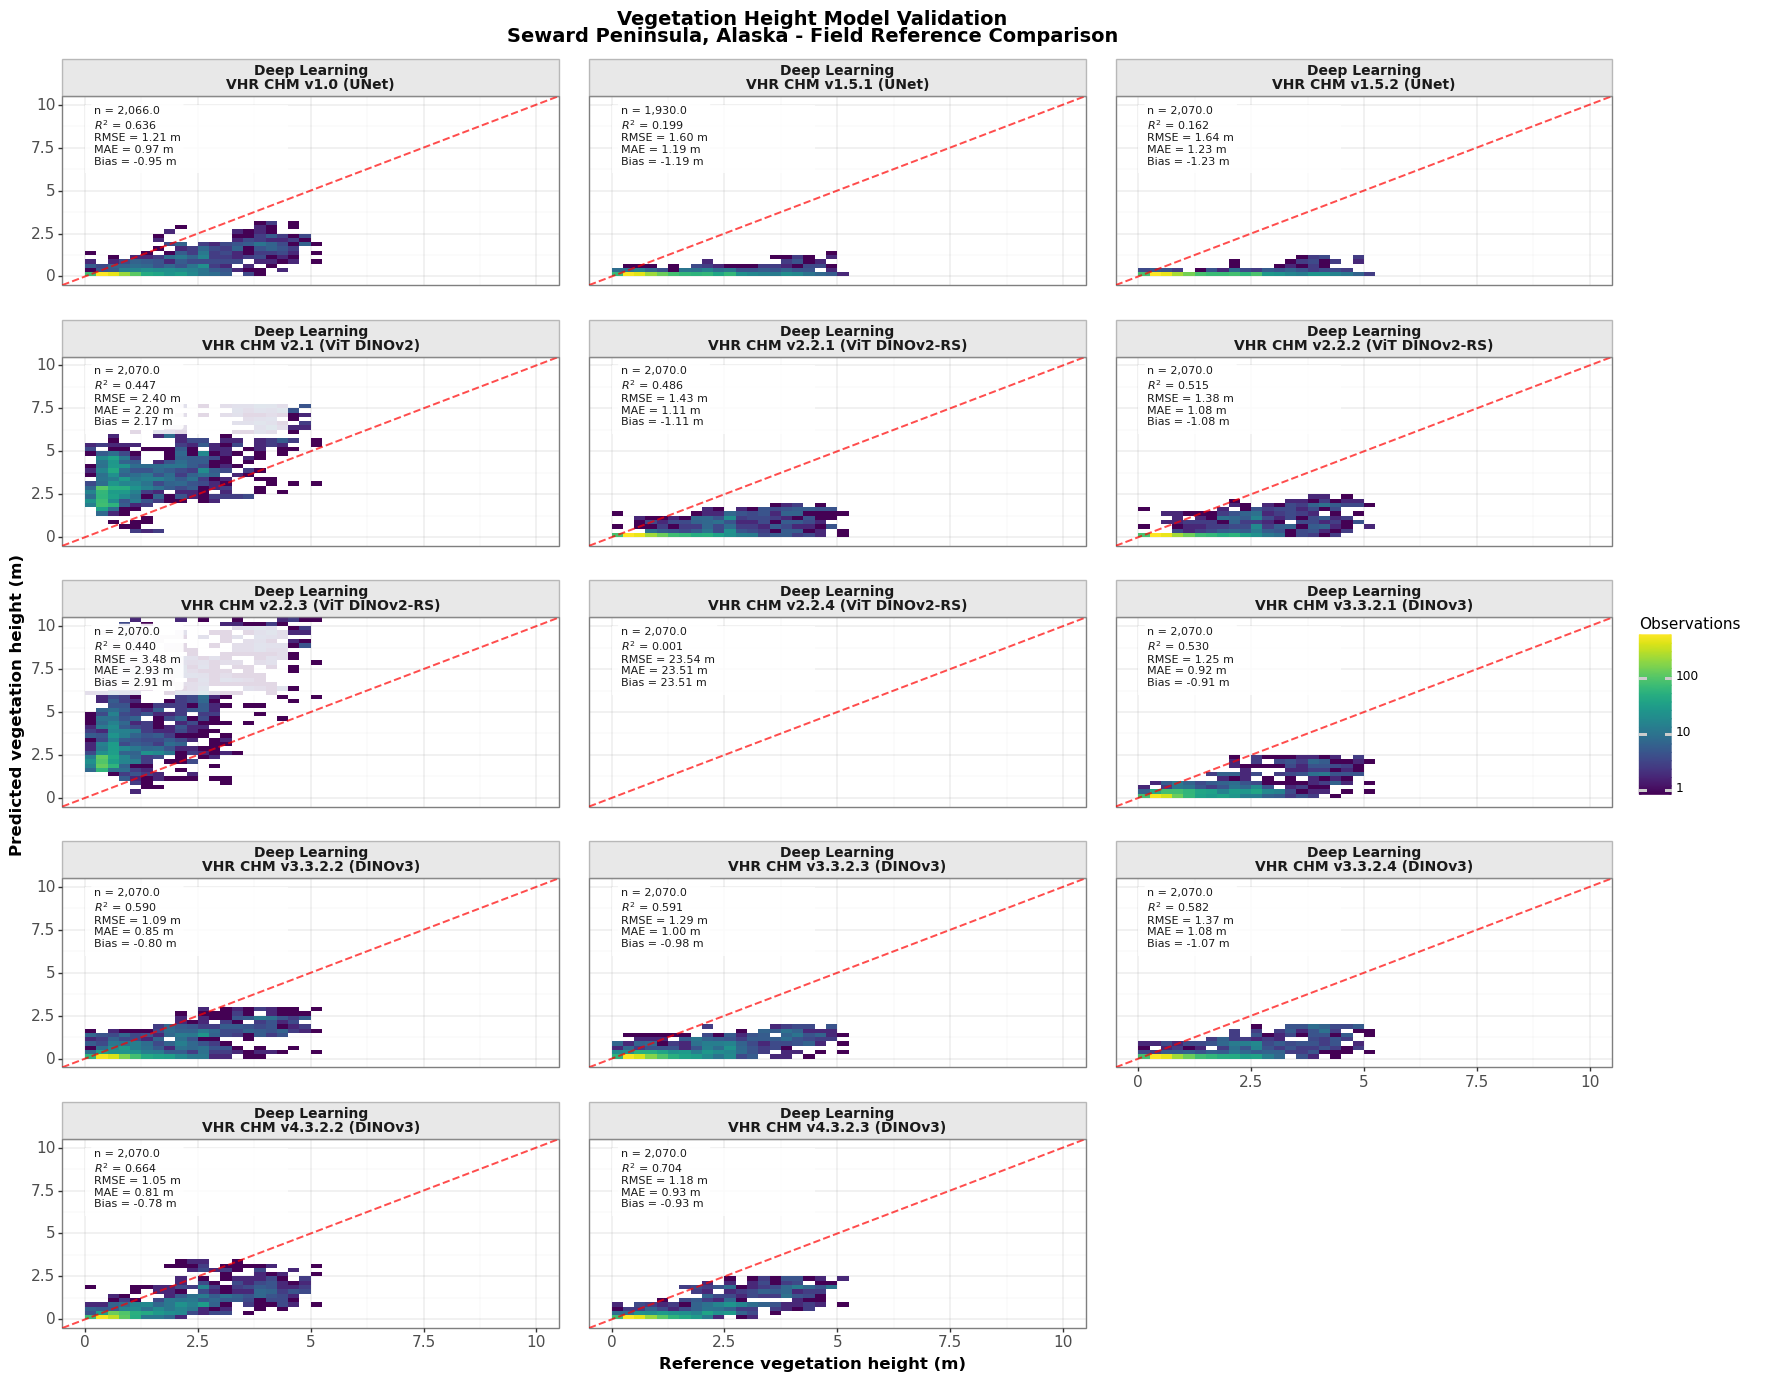

In [101]:
# =============================================================================
# USAGE EXAMPLES
# =============================================================================

# Example 1: facet_wrap with source info
plot, stats = run_validation_analysis(
    all_ref_m,
    plot_type='wrap',
    facet_wrap_vars=['source_cat', 'source_type']
)
print(plot)

Preparing dataframe...

Creating grid plot...
Rows after dropping NaN in grouping vars: 26766

=== Validation Statistics Summary ===
loss_function training_size       n    r2  rmse   mae   bias
          MSE  Large (100K)  2070.0 0.582 1.367 1.077 -1.072
          MAE  Large (100K)  2070.0 0.591 1.293 0.996 -0.978
          MAE   Full (400K) 18486.0 0.004 8.087 3.927  2.484
       custom  Large (100K)  2070.0 0.590 1.090 0.851 -0.798
       custom   Full (400K)  2070.0 0.664 1.051 0.809 -0.782


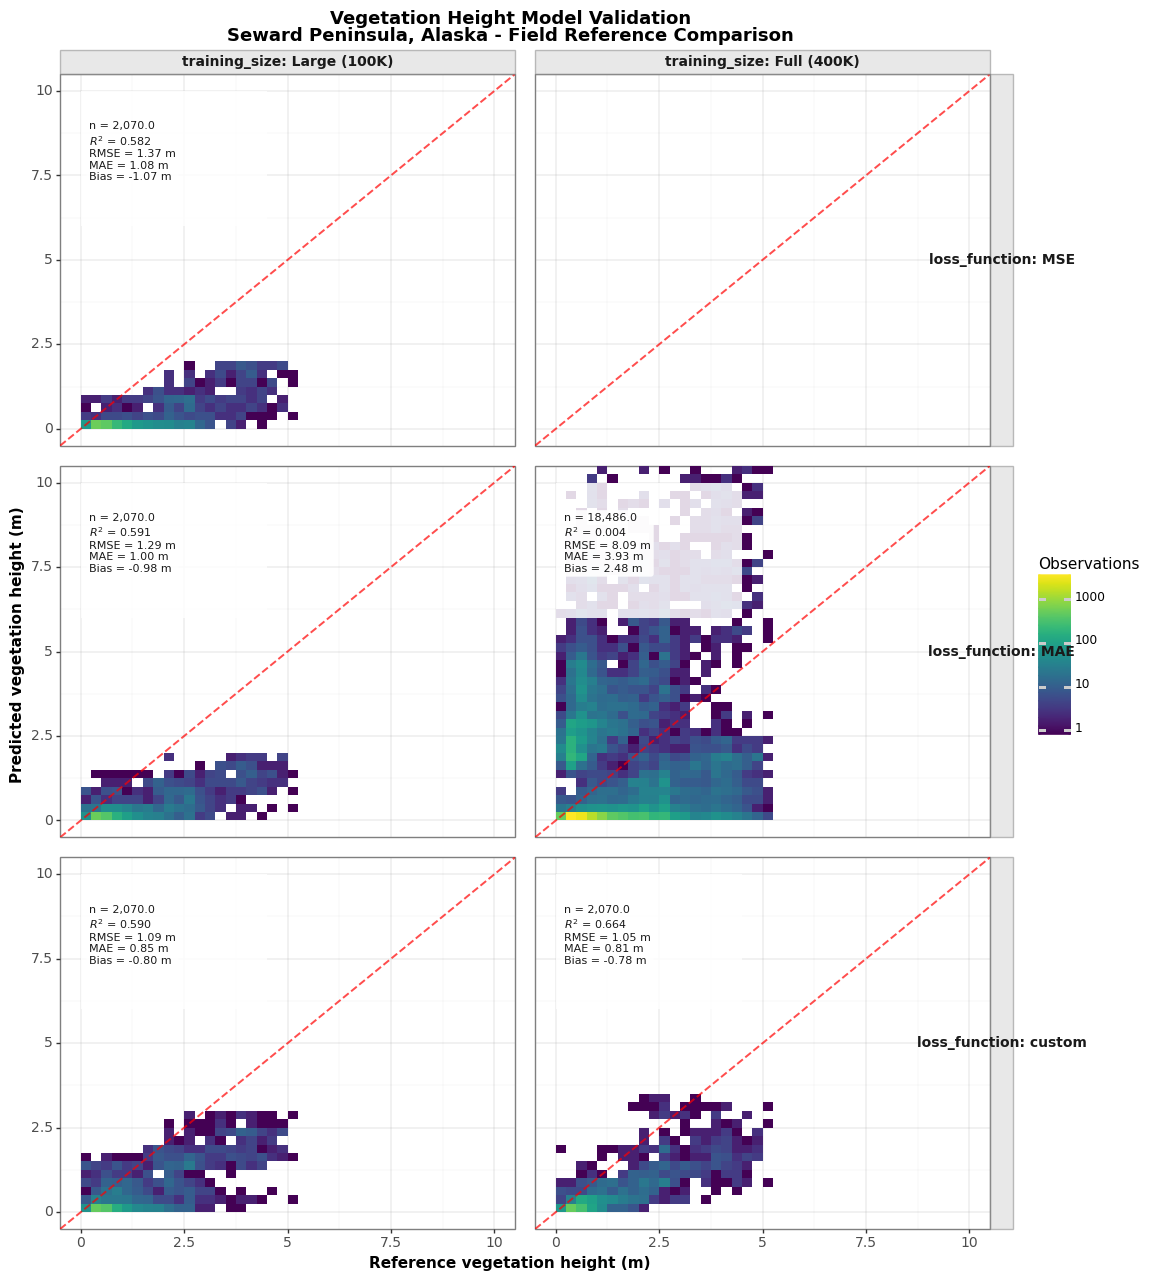

In [102]:
# Example 2: facet_grid with loss function on rows, training size on columns
plot, stats = run_validation_analysis(
    all_ref_m,
    plot_type='grid',
    facet_row_vars=['loss_function'],
    facet_col_vars=['training_size']
)
print(plot)

Preparing dataframe...

Creating grid plot...
Rows after dropping NaN in grouping vars: 26766

=== Validation Statistics Summary ===
                   source_type loss_function      n    r2   rmse    mae   bias
           VHR CHM v1.0 (UNet)           MAE 2066.0 0.636  1.213  0.966 -0.954
         VHR CHM v1.5.1 (UNet)           MAE 1930.0 0.199  1.596  1.192 -1.190
         VHR CHM v1.5.2 (UNet)           MAE 2070.0 0.162  1.638  1.225 -1.225
     VHR CHM v2.1 (ViT DINOv2)           MAE 2070.0 0.447  2.403  2.200  2.165
VHR CHM v2.2.1 (ViT DINOv2-RS)           MAE 2070.0 0.486  1.428  1.113 -1.110
VHR CHM v2.2.2 (ViT DINOv2-RS)           MAE 2070.0 0.515  1.376  1.083 -1.078
VHR CHM v2.2.3 (ViT DINOv2-RS)           MAE 2070.0 0.440  3.480  2.930  2.907
VHR CHM v2.2.4 (ViT DINOv2-RS)           MAE 2070.0 0.001 23.543 23.512 23.512
     VHR CHM v3.3.2.2 (DINOv3)        custom 2070.0 0.590  1.090  0.851 -0.798
     VHR CHM v3.3.2.3 (DINOv3)           MAE 2070.0 0.591  1.293  0.996 -0.97

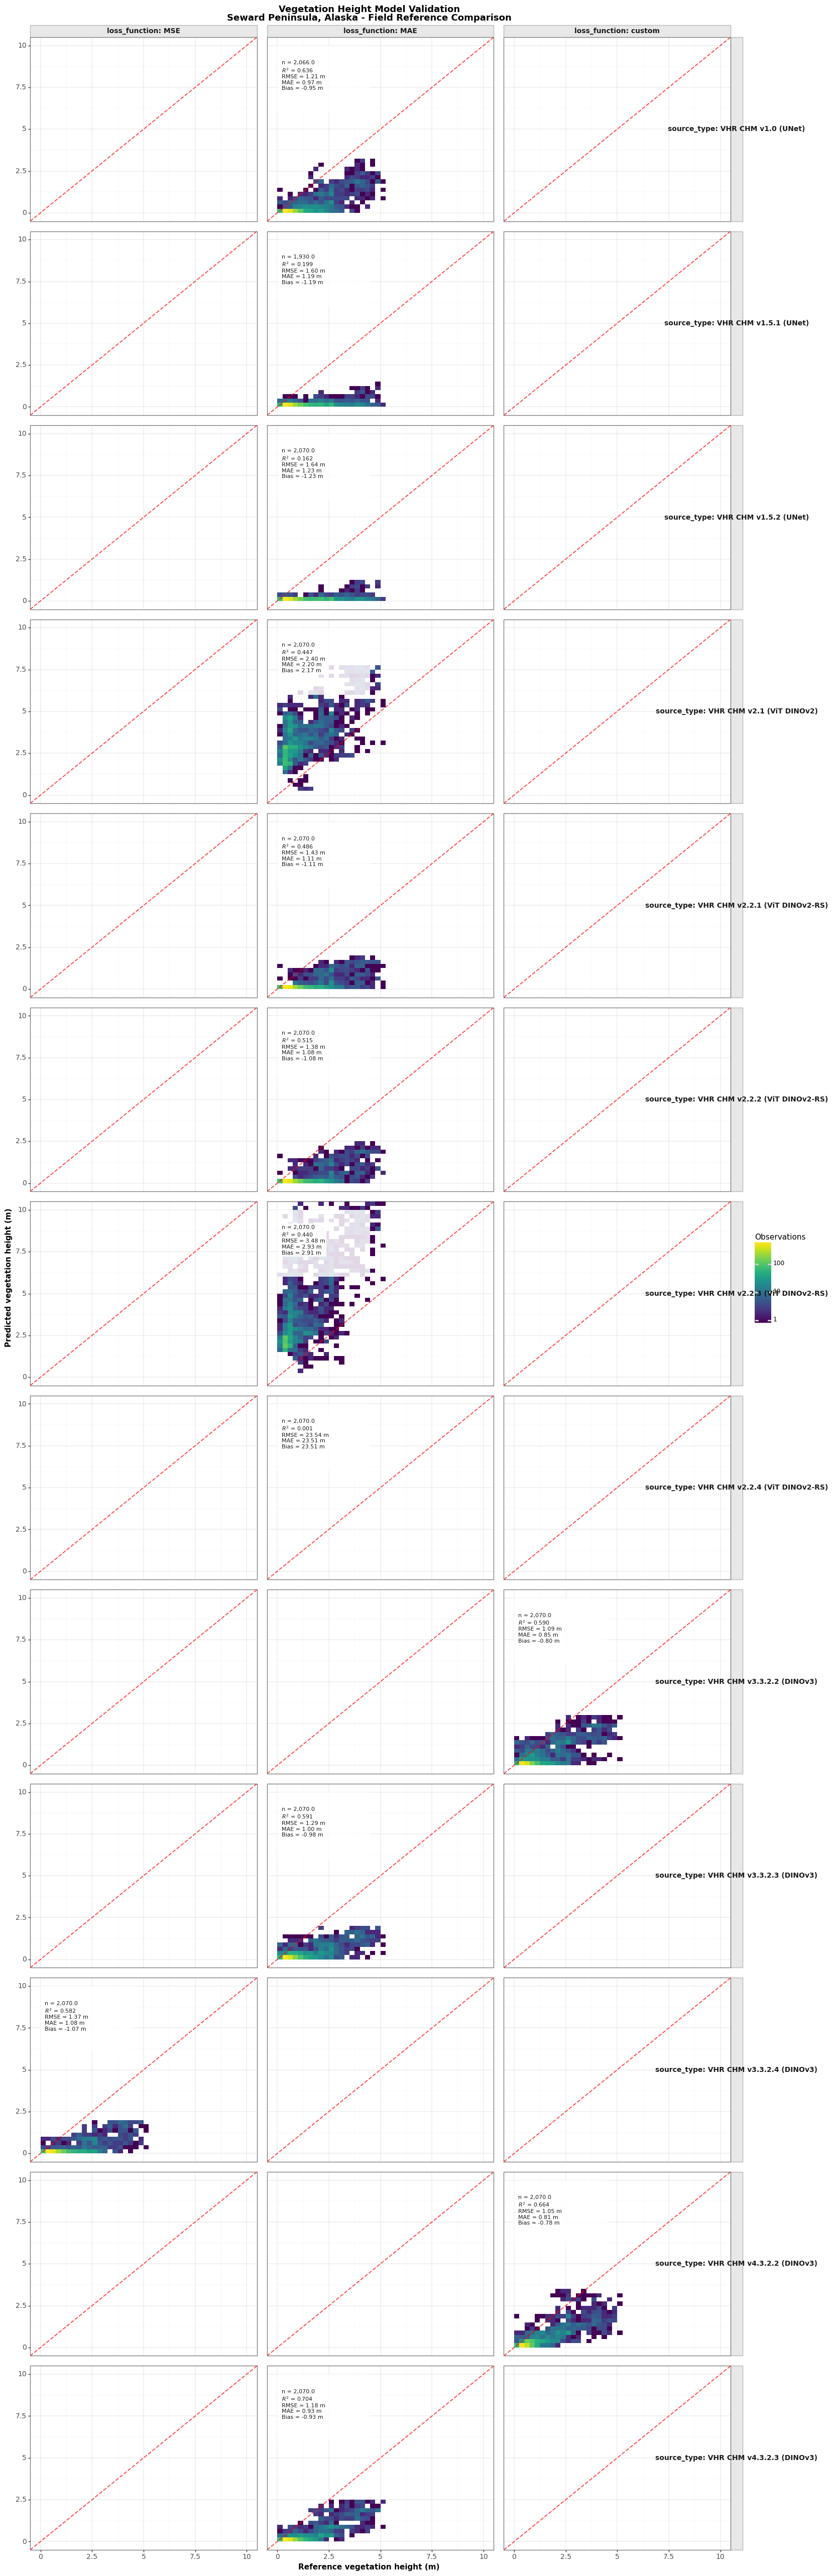

In [103]:
# Example 3: facet_grid with source_type on rows, loss_function on columns
plot, stats = run_validation_analysis(
    all_ref_m,
    plot_type='grid',
    facet_row_vars=['source_type'],
    facet_col_vars=['loss_function']
)
print(plot)

Preparing dataframe...

Creating wrap plot...

=== Validation Statistics Summary ===
     n    r2   rmse    mae   bias
2066.0 0.636  1.213  0.966 -0.954
1930.0 0.199  1.596  1.192 -1.190
2070.0 0.162  1.638  1.225 -1.225
2070.0 0.447  2.403  2.200  2.165
2070.0 0.486  1.428  1.113 -1.110
2070.0 0.515  1.376  1.083 -1.078
2070.0 0.440  3.480  2.930  2.907
2070.0 0.001 23.543 23.512 23.512
2070.0 0.704  1.180  0.934 -0.927
2070.0 0.591  1.293  0.996 -0.978
2070.0 0.582  1.367  1.077 -1.072
2070.0 0.664  1.051  0.809 -0.782
2070.0 0.590  1.090  0.851 -0.798
2070.0 0.530  1.247  0.917 -0.912


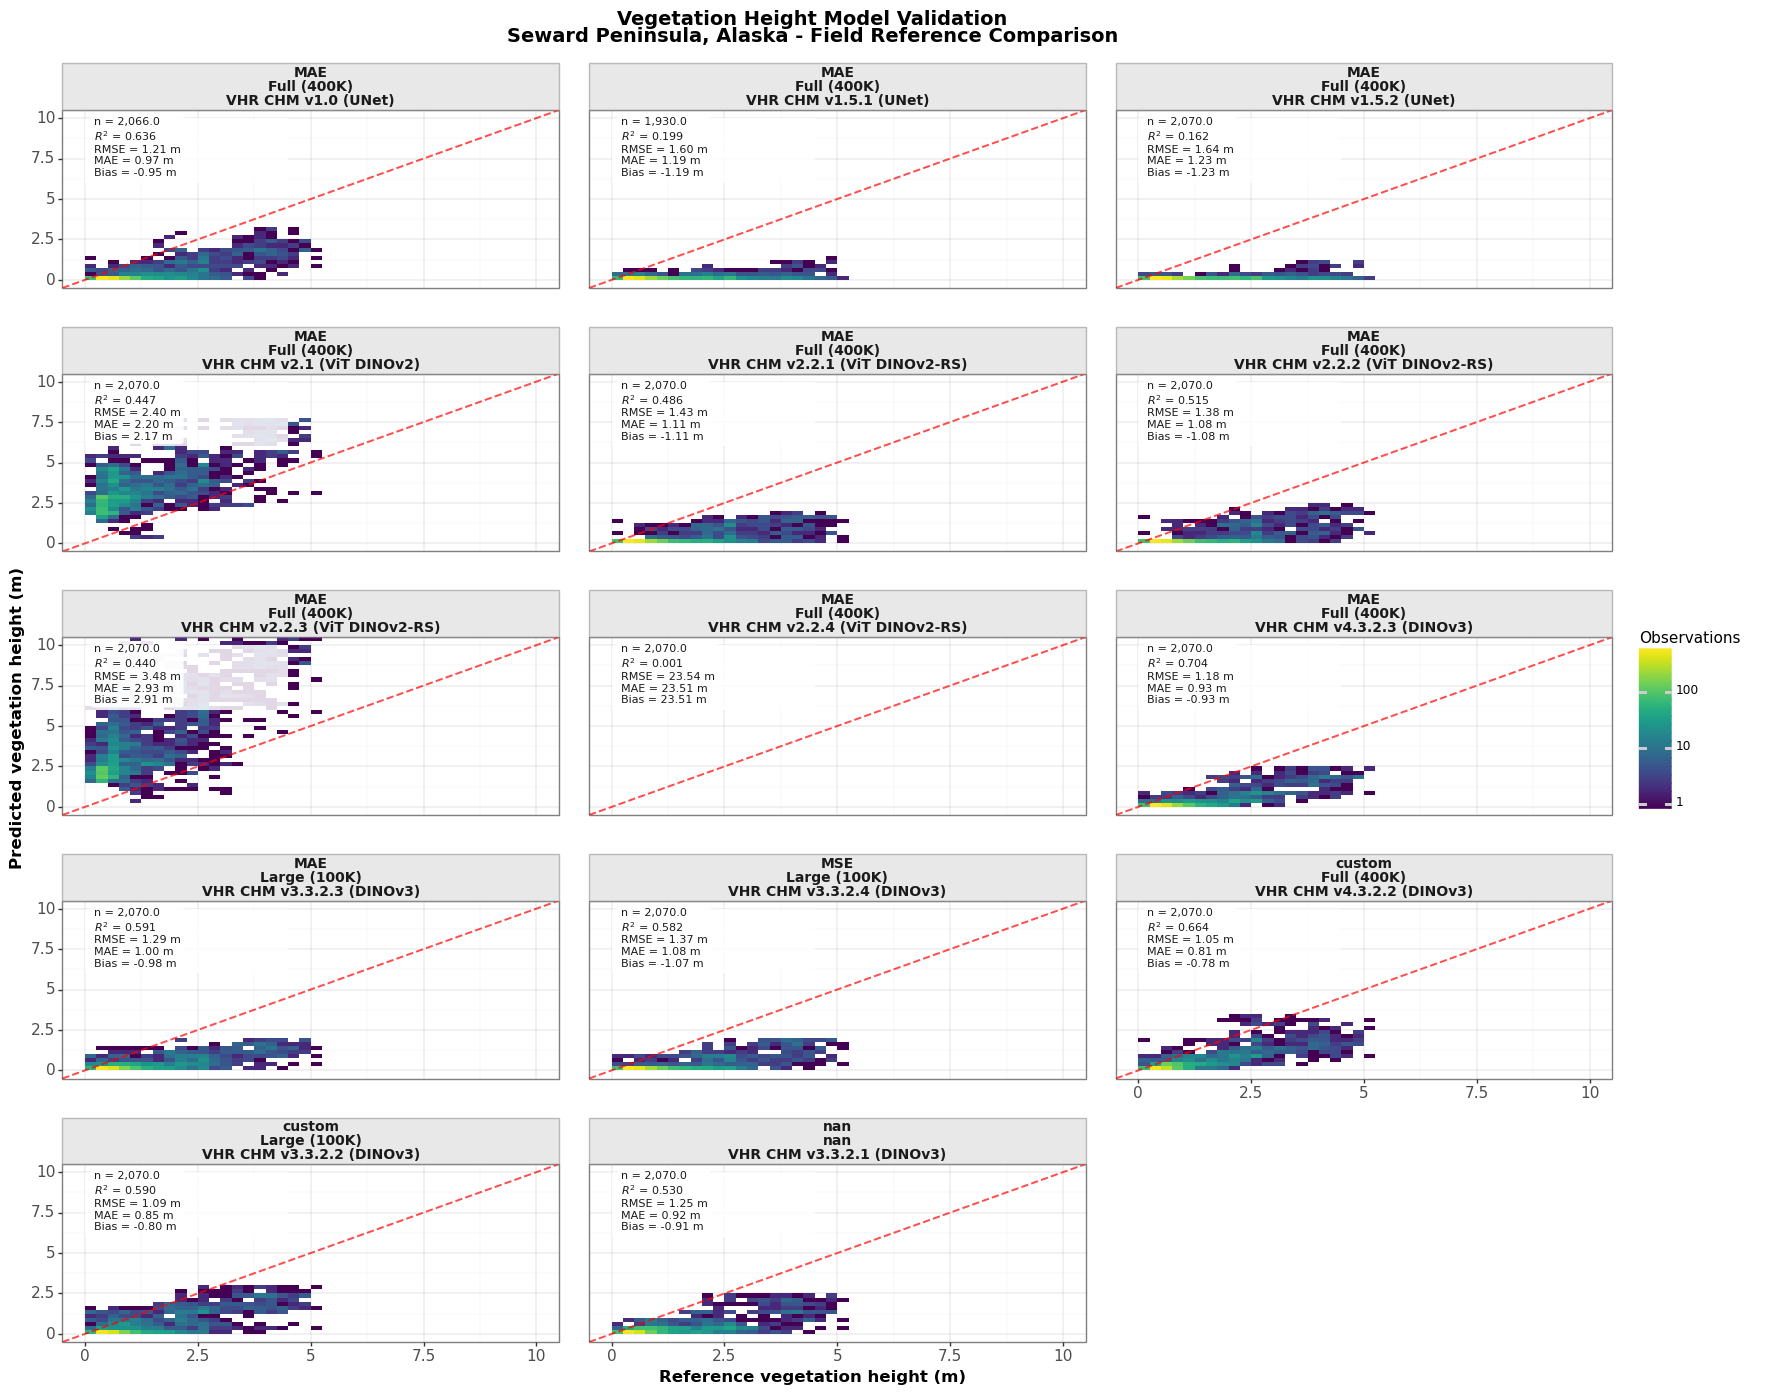

In [104]:
# Example 4: facet_wrap with new attributes
plot, stats = run_validation_analysis(
    all_ref_m,
    plot_type='wrap',
    facet_wrap_vars=['loss_function', 'training_size', 'source_type']
)
print(plot)

In [90]:








# # Example 5: Save to file
# plot, stats = run_validation_analysis(
#     all_ref_m,
#     output_dir='./plots',
#     plot_type='grid',
#     facet_row_vars=['loss_function'],
#     facet_col_vars=['training_size']
# )

Preparing dataframe...

Creating wrap plot...

=== Validation Statistics Summary ===
     n    r2   rmse    mae   bias
2066.0 0.636  1.213  0.966 -0.954
1930.0 0.199  1.596  1.192 -1.190
2070.0 0.162  1.638  1.225 -1.225
2070.0 0.447  2.403  2.200  2.165
2070.0 0.486  1.428  1.113 -1.110
2070.0 0.515  1.376  1.083 -1.078
2070.0 0.440  3.480  2.930  2.907
2070.0 0.001 23.543 23.512 23.512
2070.0 0.530  1.247  0.917 -0.912
2070.0 0.590  1.090  0.851 -0.798
2070.0 0.591  1.293  0.996 -0.978
2070.0 0.582  1.367  1.077 -1.072
2070.0 0.664  1.051  0.809 -0.782
2070.0 0.704  1.180  0.934 -0.927
Preparing dataframe...

Creating grid plot...

=== Validation Statistics Summary ===
loss_function training_size       n    r2  rmse   mae   bias
          MSE  Large (100K)  2070.0 0.582 1.367 1.077 -1.072
          MAE  Large (100K)  2070.0 0.591 1.293 0.996 -0.978
          MAE   Full (400K) 18486.0 0.004 8.087 3.927  2.484
       custom  Large (100K)  2070.0 0.590 1.090 0.851 -0.798
       custom  